In [1]:
# ===============================
# Step 1: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
# ===============================
# Step 2: Load & Explore Dataset
# ===============================
df = pd.read_csv("/content/insurance (1).csv")

print(df.head())
print(df.info())
print(df.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

In [3]:
# ===============================
# Step 3: Preprocessing
# ===============================
X = df.drop("charges", axis=1)
y = df["charges"]

categorical = ["sex", "smoker", "region"]
numerical = ["age", "bmi", "children"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical),
    ("num", StandardScaler(), numerical)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [4]:
# ===============================
# Step 4: Baseline ANN Model (Weak)
# ===============================
model_base = Sequential([
    Dense(8, input_dim=X_train.shape[1], activation="relu"),
    Dense(1)
])

model_base.compile(optimizer="adam", loss="mse", metrics=["mae"])

history_base = model_base.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=50, verbose=0)

loss_base, mae_base = model_base.evaluate(X_test, y_test, verbose=0)
print("Baseline Test MAE:", mae_base)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline Test MAE: 12896.4111328125


In [5]:
# ===============================
# Step 5: Optimized ANN Model
# ===============================
from tensorflow.keras.layers import Dropout

# Optimized model with Dropouts
model_opt = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.3),   # randomly drop 30% neurons
    Dense(64, activation="relu"),
    Dropout(0.2),   # randomly drop 20% neurons
    Dense(32, activation="relu"),
    Dropout(0.1),   # small dropout
    Dense(1)
])

model_opt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

history_opt = model_opt.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=200,
                            batch_size=32,
                            callbacks=[early_stop, reduce_lr],
                            verbose=0)

loss_opt, mae_opt = model_opt.evaluate(X_test, y_test, verbose=0)
print("Optimized (with Dropout) Test MAE:", mae_opt)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimized (with Dropout) Test MAE: 2479.432373046875


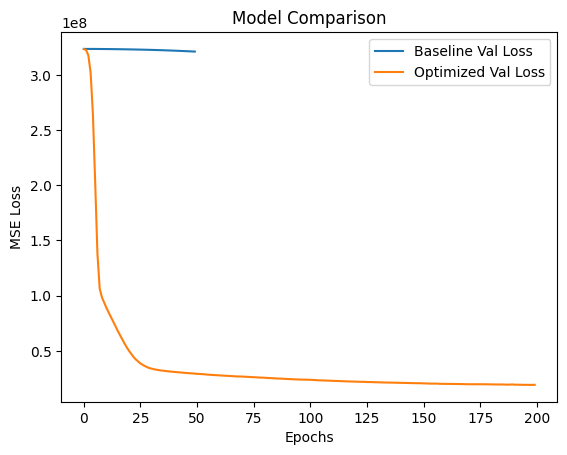

In [6]:
# ===============================
# Step 6: Compare Learning Curves
# ===============================
plt.plot(history_base.history["val_loss"], label="Baseline Val Loss")
plt.plot(history_opt.history["val_loss"], label="Optimized Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Model Comparison")
plt.show()

In [7]:
# ===============================
# Step 7: Predictions
# ===============================
# Example from test set
sample = X_test[0].reshape(1, -1)
predicted_charge = model_opt.predict(sample)
print("Predicted:", predicted_charge[0][0])
print("Actual:", y_test.iloc[0])

# Custom input example
custom_data = pd.DataFrame({
    "age": [35],
    "sex": ["male"],
    "bmi": [28],
    "children": [2],
    "smoker": ["no"],
    "region": ["southeast"]
})
custom_processed = preprocessor.transform(custom_data)
custom_pred = model_opt.predict(custom_processed)
print("Predicted charge for custom input:", custom_pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted: 8465.08
Actual: 9095.06825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted charge for custom input: 6157.579


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


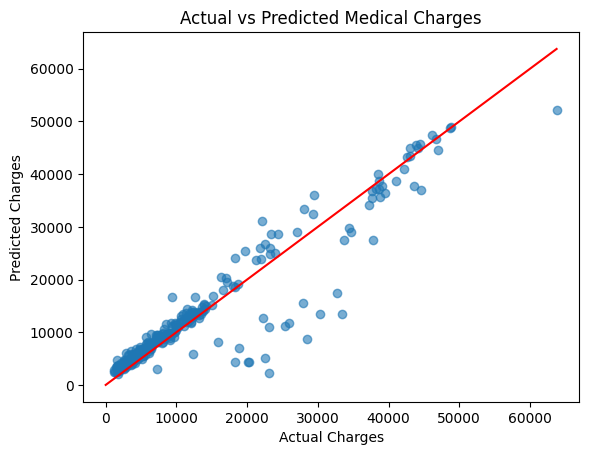

In [8]:
# ===============================
# Step 8: Actual vs Predicted Plot
# ===============================
y_pred = model_opt.predict(X_test).flatten()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Medical Charges")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.show()
